# 🧪 Laboratorio 7
Integrantes
- Diego Alexander Hernández Silvestre - 21270
- Linda Inés Jiménez Vides - 21169
- Mario Antonio Guerra Morales - 21008
- Kristopher Javier Alvarado López - 21188

## 💻 Task 1

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import imageio
from IPython.display import Image, display

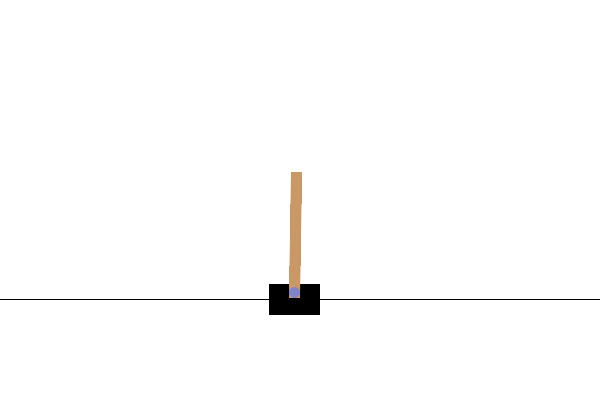

In [2]:


# Crear el entorno CartPole
env = gym.make('CartPole-v1', render_mode="rgb_array")

# Reiniciar el entorno
state, info = env.reset()

# Lista para almacenar los frames
frames = []

# Número de pasos máximos a ejecutar
num_steps = 500

# Loop para ejecutar los pasos en el entorno
for step in range(num_steps):
    # Renderizar el entorno y capturar el frame
    frame = env.render()
    frames.append(frame)

    # Seleccionar una acción: hacia la derecha si el ángulo del poste es negativo, izquierda si es positivo
    action = 0 if state[2] < 0 else 1  # Política simple basada en el ángulo del poste
    
    # Realizar la acción en el entorno
    next_state, reward, done, truncated, info = env.step(action)
    
    # Si el episodio ha terminado, reiniciar el entorno
    if done or truncated:
        state, info = env.reset()
    else:
        state = next_state

# Cerrar el entorno
env.close()

# Guardar el GIF en un archivo
gif_filename = 'data/cartpole_simulation.gif'
imageio.mimsave(gif_filename, frames, fps=30, loop=0)

# Mostrar el GIF en la celda
display(Image(filename=gif_filename))


In [3]:


env = gym.make("CartPole-v1")

def Random_games():
    # Each of this episode is its own game.
    for episode in range(10):
        env.reset()
        # this is each frame, up to 500...but we wont make it that far with random.
        for t in range(500):
            # This will display the environment
            # Only display if you really want to see it.
            # Takes much longer to display it.
            env.render()
            
            # This will just create a sample action in any environment.
            # In this environment, the action can be 0 or 1, which is left or right
            action = env.action_space.sample()

            # this executes the environment with an action, 
            # and returns the observation of the environment, 
            # the reward, if the env is over, and other info.
            next_state, reward, done, truncated, info = env.step(action)
            
            # lets print everything in one line:
            print(t, next_state, reward, done, truncated, info, action)
            if done or truncated:
                break
                
Random_games()

0 [ 0.00559229 -0.18451098 -0.04210734  0.30378687] 1.0 False False {} 0
1 [ 0.00190207  0.01118498 -0.0360316  -0.00187277] 1.0 False False {} 1
2 [ 0.00212577 -0.1834022  -0.03606906  0.27922752] 1.0 False False {} 0
3 [-0.00154228  0.01221523 -0.03048451 -0.02460976] 1.0 False False {} 1
4 [-0.00129797  0.2077608  -0.0309767  -0.32675287] 1.0 False False {} 1
5 [ 0.00285725  0.01309325 -0.03751176 -0.04399734] 1.0 False False {} 0
6 [ 0.00311911 -0.18147129 -0.03839171  0.23661828] 1.0 False False {} 0
7 [-0.00051032  0.01417753 -0.03365934 -0.06792308] 1.0 False False {} 1
8 [-2.2676471e-04  2.0976548e-01 -3.5017803e-02 -3.7103280e-01] 1.0 False False {} 1
9 [ 0.00396855  0.01515808 -0.04243846 -0.0895938 ] 1.0 False False {} 0
10 [ 0.00427171 -0.17933069 -0.04423033  0.18940352] 1.0 False False {} 0
11 [ 0.00068509  0.01639522 -0.04044227 -0.11689768] 1.0 False False {} 1
12 [ 0.001013    0.2120726  -0.04278022 -0.42206052] 1.0 False False {} 1
13 [ 0.00525445  0.4077737  -0.05122

c:\Users\mague\Downloads\Lab07_DL\.venv\Lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


In [4]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Definir redes
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
online_net = QNetwork(input_dim, output_dim)
target_net = QNetwork(input_dim, output_dim)

# Inicializar pesos de la red de destino con los de la red en línea
target_net.load_state_dict(online_net.state_dict())


<All keys matched successfully>

In [5]:
# Definición de hiperparámetros
gamma = 0.99  # Factor de descuento
epsilon = 1.0  # Parámetro de exploración inicial
epsilon_decay = 0.995  # Decaimiento de epsilon
epsilon_min = 0.01  # Valor mínimo de epsilon
lr = 0.001  # Tasa de aprendizaje
batch_size = 64  # Tamaño del batch
memory_size = 10000  # Tamaño de la memoria de experiencia
target_update_freq = 10  # Frecuencia de actualización de la red de destino


In [6]:
def epsilon_greedy_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # Exploración
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = online_net(state)
        return torch.argmax(q_values).item()  # Explotación

In [7]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones))

replay_buffer = ReplayBuffer(memory_size)

In [ ]:
# Ciclo de entrenamiento

In [ ]:
# Representar el entorno

In [ ]:
# Supervisar el entrenamiento

In [ ]:
# Evalúe el rendimiento

In [ ]:
# Fine-Tuning

## 💻 Task 2

### Defina en qué consiste y en qué clase de problemas se pueden usar cada uno de los siguientes acercamientos en Deep Reinforcement Learning:

**1. Proximal Policy Optimization**
* Respuesta

**2. Deep Deterministic Policy Gradients (DDPG)**
* Respuesta

**3. Trust Region Policy Optimization (TRPO)**
* Respuesta

**4. Asynchronous Advantage Actor-Critic (A3C)**
* Respuesta